# Neural Network Classifier

Debido a que para este modelo no se logró asegurar la reproducibilidad, todo lo comentaro sera de forma general.

In [1]:
from common import get_prediction, split_data, get_data
import preprocessing as prep

## Cargamos el dataset

In [2]:
data = get_data()
data.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,4d,Señor Camilo Pedro,117,hombre,73.5,0,0,59258;,1,NaN,fiumark_quilmes
1,4d,Señora Raquel Angelica,658,mujer,35.0,1,1,586:6;,2,NaN,fiumark_quilmes
2,normal,Señor Antonio Federico,794,hombre,NaN,0,0,"RE""39822",3,NaN,fiumark_chacarita
3,4d,Señor Osvaldo Aureliano,455,hombre,NaN,0,0,"C17""4:39",1,NaN,fiumark_palermo
4,4d,Señorita Rita Eudosia,173,mujer,4.0,1,1,569964,2,NaN,fiumark_palermo


In [3]:
pred = get_prediction()
pred.head()

0    0
1    0
2    0
3    0
4    1
Name: volveria, dtype: int64

## Dividimos los datos

Separamos un validation para los modelos

In [4]:
X_train_val, X_val_2, y_train_val, y_val_2 = split_data(data, pred)
X_train_val.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
239,normal,Señor Celestino Miguel,797,mujer,52.0,0,0,39687,3,adelante,fiumark_palermo
281,4d,Señora Reina Benita,141,mujer,NaN,0,2,489:,2,NaN,fiumark_chacarita
504,3d,Señor Emeterio de Jesus,309,hombre,33.0,1,0,"R1RR""55:3",3,NaN,fiumark_chacarita
230,4d,Señor Juan Jorge Alberto,158,hombre,33.0,0,0,"UQVQP1QS""5;42;2",1,NaN,fiumark_palermo
738,4d,Señor Pablo Augusto,495,hombre,24.0,0,0,"C16""675:2",1,NaN,fiumark_palermo


Separamos otro validation para elegir el mejor modelo en una familia de modelos con el mejor preprocesado

In [5]:
X_train, X_val, y_train, y_val = split_data(X_train_val, y_train_val)
X_train.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
475,4d,Señor Ignacio Nazar,689,hombre,21.0,0,0,572258,1,NaN,fiumark_palermo
247,4d,Señor Abel Omar,644,hombre,NaN,0,0,3823,6,NaN,fiumark_palermo
726,normal,Señor Fausto Rene,468,hombre,59.0,0,0,3359;4,3,NaN,fiumark_palermo
106,3d,Señora Irma Pascualina,707,mujer,48.0,0,0,4457;8,2,NaN,fiumark_palermo
206,4d,Señor Ovidio Valentin,871,hombre,29.0,0,0,56;46:,1,NaN,fiumark_palermo


## Entrenamos los modelos

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras import metrics
import keras

Using TensorFlow backend.


Preparamos los preprocesados

In [7]:
# Con la columna fila
prep_base_1 = prep.Preprocessing(
    [prep.Drop_high_cardinals(), prep.Dummy_variables()]
)

# Rellenado de nan con zeros
prep_1 = prep.Preprocessing(
    [prep_base_1, prep.Nan_to_zero()]
)

# Rellenado de nan con la media
prep_2 = prep.Preprocessing(
    [prep_base_1, prep.Nan_to_mean()]
)

# Rellenado de nan con la moda
prep_3 = prep.Preprocessing(
    [prep_base_1, prep.Nan_to_mode()]
)

# Rellenado de nan con la median
prep_4 = prep.Preprocessing(
    [prep_base_1, prep.Nan_to_median()]
)

In [8]:
list_preprocessing = [
    prep_1, prep_2, prep_3, prep_4,
]

Vemos como es un preprocesado

In [9]:
prep_1.fit(X_train)
X_train_ = prep_1.transform(X_train)
X_train_.head()

,edad,amigos,parientes,precio_ticket,tipo_de_sala_4d,tipo_de_sala_normal,genero_mujer,fila_medio,fila_nan,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan
475,21.0,0,0,1,1,0,0,0,1,1,0,0
247,0.0,0,0,6,1,0,0,0,1,1,0,0
726,59.0,0,0,3,0,1,0,0,1,1,0,0
106,48.0,0,0,2,0,0,1,0,1,1,0,0
206,29.0,0,0,1,1,0,0,0,1,1,0,0


In [10]:
X_train_.shape[1]

12

Vemos que tiene 12 atributos, por lo tanto la primera capa de la red neuronal tendra esa cantidad de entradas.

Definimos una funcion que añade las capas, optimizadores, funcion de activacion y dropout al modelo; y lo devuelve

In [11]:
#input_shape = atributos despues del preprocesado
def create_model(nl1=1, nl2=0,  nl3=0, opt='SGD',
                 nn1=80, nn2=0, nn3 = 0, lr=0.01, l1=0, l2=0,
                 act = 'tanh', dropout=0, input_shape=12, output_shape=1):

    if(opt == 'RMSprop'):
        opt = keras.optimizers.RMSprop(lr=lr)
    elif(opt == 'Adam'):
        opt = keras.optimizers.Adam(lr=lr)
    elif(opt == 'Adadelta'):
        opt = keras.optimizers.Adadelta(lr=lr)
    elif(opt == 'Adagrad'):
        opt = keras.optimizers.Adagrad(lr=lr)
    else:
        opt = keras.optimizers.SGD(lr=lr)
    
    reg = keras.regularizers.l1_l2(l1=l1, l2=l2)

    model = Sequential()
    
    # Para la primera capa
    first=True
    
    for i in range(nl1):
        if first:
            model.add(Dense(nn1, input_dim=input_shape, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(Dense(nn1, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(Dropout(dropout))
            
    for i in range(nl2):
        if first:
            model.add(Dense(nn2, input_dim=input_shape, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(Dense(nn2, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(Dropout(dropout))
            
    for i in range(nl3):
        if first:
            model.add(Dense(nn3, input_dim=input_shape, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(Dense(nn3, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(Dropout(dropout))
            
    model.add(Dense(output_shape, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[metrics.AUC()])
    return model

Para decidir el mejor modelo compararemos varios preprocesados y varias combinaciones de parametros.

### 1. Modelo por defecto

Usando el wrapper de keras creamos el modelo

In [12]:
model = KerasClassifier(build_fn=create_model, epochs=100, verbose=0)

In [13]:
params = {
    #empty
}

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from common import super_training

models_preprocessing_1 = super_training(
    X_train, y_train, list_preprocessing,
    GridSearchCV(
        model, params, scoring='roc_auc', n_jobs=-1, cv=5
    )
)

In [15]:
from common import get_proba_predicts

proba_predicts = get_proba_predicts(models_preprocessing_1, X_val)

<Figure size 432x288 with 0 Axes>

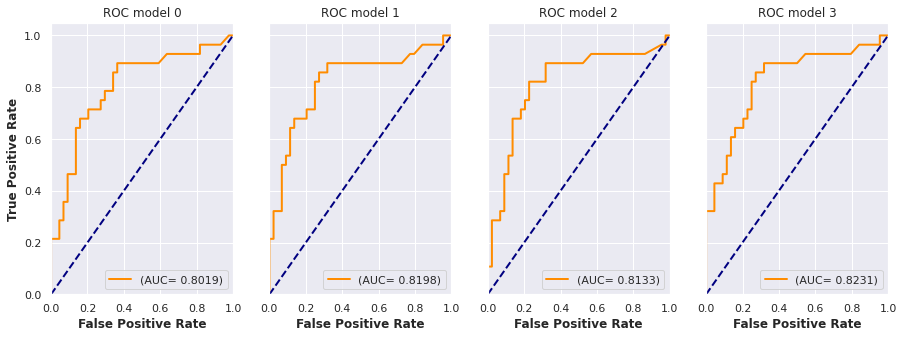

In [16]:
from common import plot_rocs

# Guardamos el indice del modelo con mejor score
best_model_index = plot_rocs(proba_predicts, y_val, 4, 1)

Elegimos el mejor modelo y preprocesado

In [17]:
best_nnc_prep_1 = models_preprocessing_1[best_model_index]

Ahora veremos que pasa si variamos la cantidad de capas y neuronas

### 2. Variando numero de capas y neuronas

In [18]:
model = KerasClassifier(build_fn=create_model, epochs=100, verbose=0)

Definimos los parametros que queremos probar

In [19]:
nl1 = [0, 1, 2]
nl2 = [0, 1, 2]
nl3 = [0, 1, 2]
nn1=[1, 20, 80]
nn2=[0, 1, 20, 40]
nn3=[0, 1, 10, 50]

# dictionary summary
param_grid = dict(
    nl1=nl1, nl2=nl2, nl3=nl3, nn1=nn1, nn2=nn2, nn3=nn3
)

In [20]:
# 7 minutos en entrenar
models_preprocessing_2 = super_training(
    X_train, y_train, list_preprocessing,
    RandomizedSearchCV(
        model, param_grid, n_iter=20, 
        random_state=20, scoring='roc_auc', n_jobs=-1, cv=5
    )
)

In [21]:
proba_predicts = get_proba_predicts(models_preprocessing_2, X_val)

<Figure size 432x288 with 0 Axes>

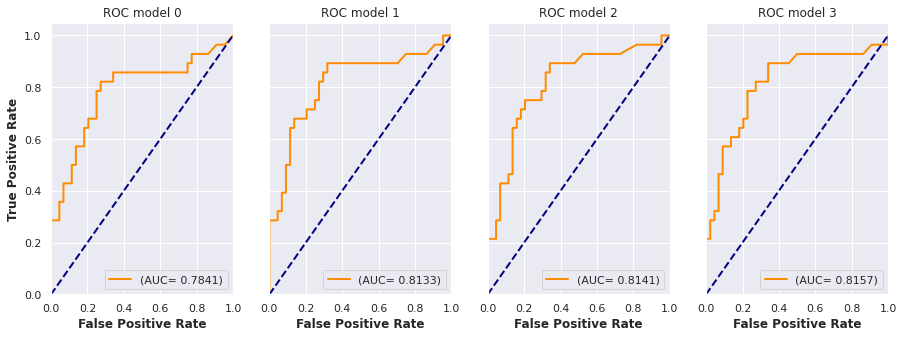

In [22]:
best_model_index = plot_rocs(proba_predicts, y_val, 4, 1)

Escogemos el mejor

In [23]:
best_nnc_prep_2 = models_preprocessing_2[best_model_index]

Ahora vemos el resto de los parametros.

### 2. Resto de parametros

In [24]:
nl1 = [0, 1, 2]
nl2 = [0, 1, 2]
nl3 = [0, 1, 2]
nn1=[1, 20, 80]
nn2=[0, 1, 20, 40]
nn3=[0, 1, 10, 50]

# learning algorithm parameters
lr=[1e-2, 1e-3, 1e-4]

# activation
activation=['relu', 'sigmoid', 'tanh']

# dropout and regularisation
dropout = [0, 0.1, 0.2, 0.3]
l1 = [0, 0.01, 0.003, 0.001]
l2 = [0, 0.01, 0.003, 0.001]

#optimizers
opt = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad']

# dictionary summary
param_grid = dict(
    nl1=nl1, nl2=nl2, nl3=nl3, nn1=nn1, nn2=nn2, nn3=nn3,
    act=activation, l1=l1, l2=l2, lr=lr, dropout=dropout, opt=opt
)

In [25]:
model = KerasClassifier(build_fn=create_model, epochs=100, verbose=0)

In [26]:
models_preprocessing_3 = super_training(
    X_train, y_train, list_preprocessing,
    RandomizedSearchCV(
        model, param_grid, n_iter=20, 
        random_state=20, scoring='roc_auc', n_jobs=-1, cv=5
    )
)

In [27]:
proba_predicts = get_proba_predicts(models_preprocessing_3, X_val)

<Figure size 432x288 with 0 Axes>

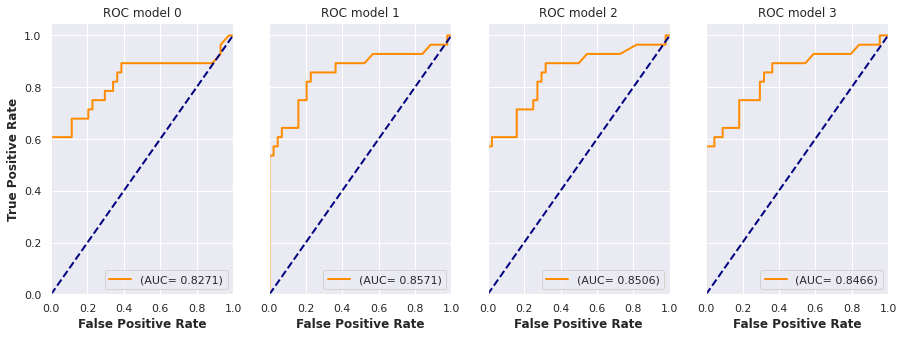

In [28]:
best_model_index = plot_rocs(proba_predicts, y_val, 4, 1)

Escogemos el mejor

In [29]:
best_nnc_prep_3 = models_preprocessing_3[best_model_index]

### 3. Vemos el mejor modelo de todos los anteriores

In [30]:
models_preprocessing_final = [best_nnc_prep_1, best_nnc_prep_2, best_nnc_prep_3]

In [31]:
proba_predicts = get_proba_predicts(models_preprocessing_final, X_val)

<Figure size 432x288 with 0 Axes>

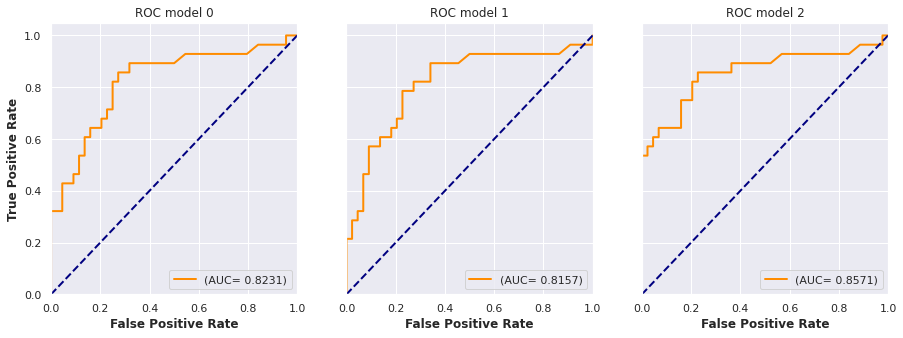

In [32]:
best_model_index = plot_rocs(proba_predicts, y_val, 3, 1)

Nuevamente escogemos el mejor

In [33]:
best_nnc, preprocessing = models_preprocessing_final[best_model_index]

Vemos que hace su preprocesado

In [34]:
preprocessing.function()

Elimina las columnas con alta cardinalidad
Transforma las variables categoricas en dummy variables
Rellena los nan de edad con la media


Vemos sus parametros

In [35]:
best_nnc.get_params()

{'epochs': 100,
 'verbose': 0,
 'opt': 'Adagrad',
 'nn3': 10,
 'nn2': 40,
 'nn1': 20,
 'nl3': 0,
 'nl2': 1,
 'nl1': 1,
 'lr': 0.01,
 'l2': 0,
 'l1': 0,
 'dropout': 0.2,
 'act': 'tanh',
 'build_fn': <function __main__.create_model(nl1=1, nl2=0, nl3=0, opt='SGD', nn1=80, nn2=0, nn3=0, lr=0.01, l1=0, l2=0, act='tanh', dropout=0, input_shape=12, output_shape=1)>}

## Vemos las métricas

Preprocesamos

In [36]:
X_val_2_ = preprocessing.transform(X_val_2)
X_val_2_.head()

,edad,amigos,parientes,precio_ticket,tipo_de_sala_4d,tipo_de_sala_normal,genero_mujer,fila_medio,fila_nan,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan
713,24.0,0,1,8,0,1,0,0,0,1,0,0
370,22.0,0,0,1,1,0,0,0,1,1,0,0
114,35.5,1,0,3,0,0,0,0,1,0,0,0
323,22.0,0,0,1,1,0,1,0,1,0,1,0
131,7.0,0,2,3,1,0,1,0,1,1,0,0


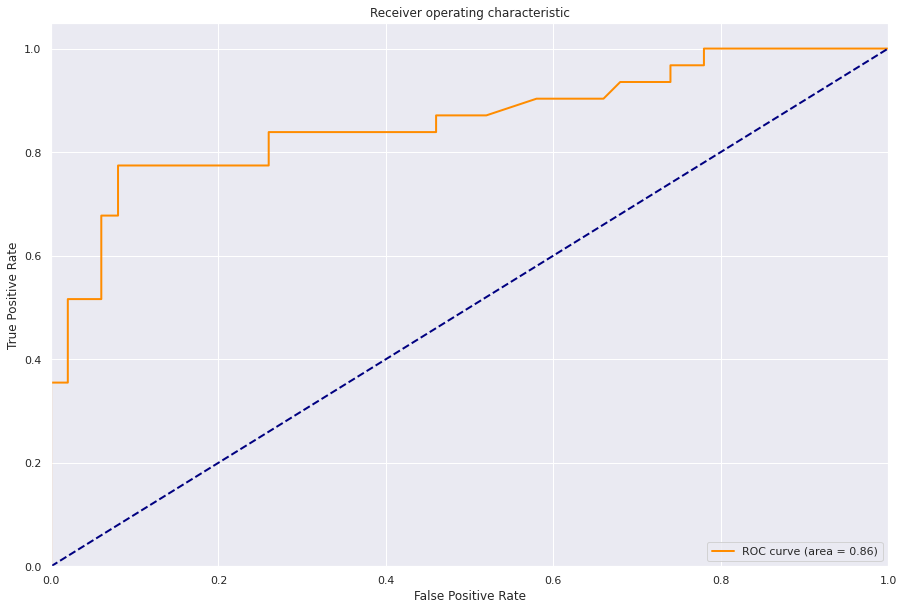

0.8593548387096774

In [37]:
from common import plot_roc
plot_roc(y_val_2, best_nnc.predict_proba(X_val_2_)[:,1])

/home/alexander/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


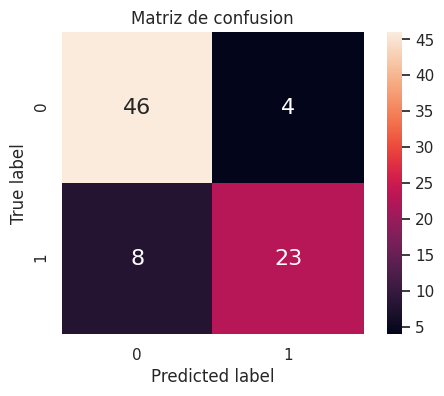

In [38]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusion")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


plot_confusion_matrix(y_val_2, best_nnc.predict(X_val_2_))

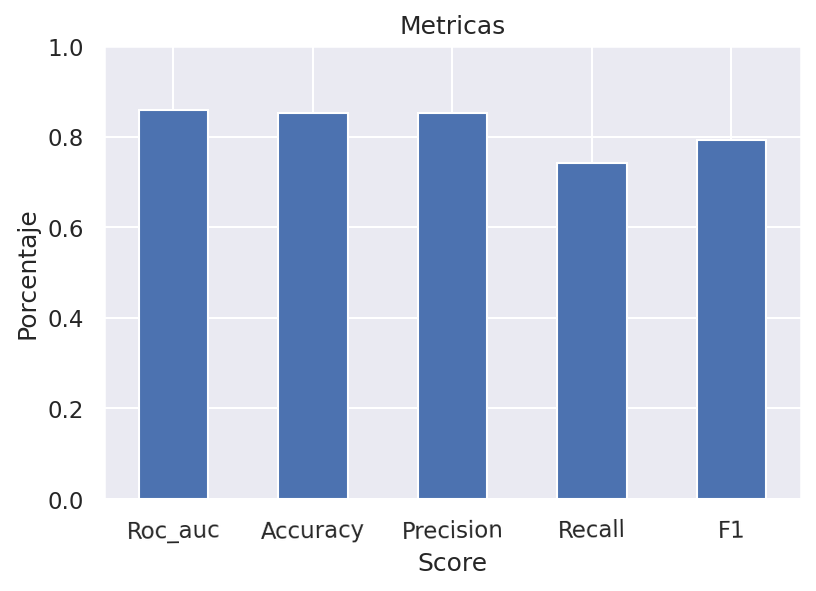

Roc_auc      0.859355
Accuracy     0.851852
Precision    0.851852
Recall       0.741935
F1           0.793103
dtype: float64

In [39]:
from common import plot_metrics
plot_metrics(
    y_val_2, 
    best_nnc.predict_proba(X_val_2_)[:,1], 
    best_nnc.predict(X_val_2_)
)

# Hacemos la predicción sobre el holdout de la empresa

In [41]:
from common import get_holdout
X_holdout_empresa = get_holdout()
X_holdout_empresa.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,4d,Señorita Beatriz Estela,650,mujer,26.0,0,0,"EC0""4536",1,NaN,fiumark_palermo
1,4d,Señorita Elena Herminda,234,mujer,8.0,4,2,569299,4,NaN,fiumark_palermo
2,normal,Señor Humberto Americo,31,hombre,43.0,0,0,"RE""39823",3,NaN,fiumark_chacarita
3,3d,Señor Casiano,552,hombre,30.0,0,0,46657:,3,NaN,fiumark_palermo
4,4d,Señor Gregorio Nicolas,411,hombre,NaN,0,0,56;444,1,NaN,fiumark_palermo


Preprocesamos el holdout de la empresa con el mejor preprocesamiento para este modelo y separamos 

In [42]:
ussers = X_holdout_empresa['id_usuario']
X_holdout_empresa_ = preprocessing.transform(X_holdout_empresa)
X_holdout_empresa_.head()

,edad,amigos,parientes,precio_ticket,tipo_de_sala_4d,tipo_de_sala_normal,genero_mujer,fila_medio,fila_nan,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan
0,26.000000,0,0,1,1,0,1,0,1,1,0,0
1,8.000000,4,2,4,1,0,1,0,1,1,0,0
2,43.000000,0,0,3,0,1,0,0,1,0,0,0
3,30.000000,0,0,3,0,0,0,0,1,1,0,0
4,32.960478,0,0,1,1,0,0,0,1,1,0,0


Predecimos con el mejor modelo

In [43]:
volveria = best_nnc.predict(X_holdout_empresa_)
volveria[0:5]

array([[1],
       [0],
       [0],
       [0],
       [0]])

Lo convertimos a una lista

In [44]:
volveria_list = []
for array in volveria:
    volveria_list.append(array[0])
    
volveria_list[0:5]

[1, 0, 0, 0, 0]

Generamos el dataframe de las predicciones

In [45]:
import pandas as pd
predictions = pd.DataFrame({
    'id_usuario': ussers, 
    'volveria': volveria_list
})
predictions.head()

,id_usuario,volveria
0,650,1
1,234,0
2,31,0
3,552,0
4,411,0


Guardamos el archivo

In [46]:
predictions.to_csv(
    'NeuralNetworkClassifier.csv', 
    columns=predictions.columns, 
    index=False
)